IMPORT LIBRARY

In [5]:
import sys, os
current_dir = os.getcwd()
project_root = current_dir[:current_dir.find("src") - 1]
sys.path.insert(0, project_root)

import pandas as pd
from data_selector import Data_selector
from feature_modifier import Feature_selector, Feature_adder
from logs.logger import CustomLogger
from models import Random_Forest, Linear
from src.root import get_root

logger = CustomLogger(name="model_main", log_file_name='model_main.log').get_logger()

READ CSV

In [7]:
df_row = pd.read_csv(get_root() +"/data/processed/integrated.csv", encoding='utf-8')

feature_adder = Feature_adder(df_row)
feature_adder.add_season()

df_modified = df_row.copy(deep=True)

df_modified['date'] = pd.to_datetime(df_modified['date'])
df_modified['datetime'] = df_modified['date'] + pd.to_timedelta(df_row['hour'], unit='h')

df = df_modified

Spilit to Dictionary

In [8]:
def select_dict(df,goup, features_to_drop=None):
        if features_to_drop is not None:
            df_t = df.drop(columns=features_to_drop, axis=1)
        
        df_dict = {k: v.drop(columns=goup) for k, v in df_t.groupby(goup)}
        
        X_dict = {}
        y_dict = {}
        
        for k in df_dict:
            v_df = df_dict[k]
            categorical_cols = v_df.select_dtypes(include=['object', 'category']).columns
            dfl = pd.get_dummies(v_df, columns=categorical_cols, drop_first=True).dropna()
            if not dfl.empty:
                X_dict[k] = dfl.drop(columns=["generation"])
                y_dict[k] = dfl["generation"]

        logger.debug(f"Features training is applied on: {df.columns}")

        return X_dict, y_dict

In [9]:
feature_to_be_dropped = ['id', 'hour', 'date', 'status', 'declare','wind_direction']
X_dict, y_dict = select_dict(df_modified,["name","code"],feature_to_be_dropped)

Find Match

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def dot_vectors(pick_df,tmep_df,time_df):
    a1 = pick_df.to_numpy()
    a2 = tmep_df.to_numpy()
    a3 = time_df.to_numpy()
    lv = []
    m1 = np.mean(a1)
    for i in range(0,len(a2)-len(a1)):
        m2 = np.mean(a2[-(i+1):-(i+len(a1)):-1])
        lv.append(sum(  (a1[-(k+1)]-m1)  *  (a2[-(i+k+1)]-m2) for k in range(len(a1))))
    lv = np.array(lv)
    return lv

def get_dphase(t1s,t2s,flag=False):
    t1 = pd.to_datetime(t1s)
    t2 = pd.to_datetime(t2s)
    t0 = t1 - np.timedelta64(12,'h')
    pick_df = df_i[(df_i['datetime'] >= t1) & (df_i['datetime'] <= t2)]["generation"]
    tmep_df = df_i[(df_i['datetime'] >= t0) & (df_i['datetime'] <= t2)]["temperature"]
    time_df = df_i[(df_i['datetime'] >= t0) & (df_i['datetime'] <= t2)]["datetime"]
    n = len(tmep_df)-len(pick_df)
    #print("n",n,t1s,t2s,pick_df)
    lv = dot_vectors(pick_df,tmep_df,time_df)
    
    time = np.arange(0,n)
    if flag:
        plt.plot(time,lv)
        plt.show()
        print(lv.argmin())
        
    return lv.argmin(),lv

df_i = df[(df["name"] == "پرند") & (df["code"] == "G11")]
times_pick = [(date + np.timedelta64(14,'h'),date + np.timedelta64(22,'h') ) for date in df_i["date"].unique()]
    
d_get_dphase = []

for s1,s2 in times_pick:
    st = df_i[df_i["datetime"] == s1][["status","value"]]
    x,lv = get_dphase(s1,s2)
    d_get_dphase.append(x)
    # if x in [2,3] : get_dphase(s1,s2,True)#print(s1,s2,st.iat[0,0],st.iat[0,1],"->",get_dphase(s1,s2,True))

In [11]:
a,b = np.unique(np.array(d_get_dphase), return_counts=True)
for i in range(len(a)):
   print(a[i],b[i])

0 252
1 160
2 255
3 235
4 142
5 72
6 31
7 12
8 10
9 19
10 48
11 224
35 1


انتخاب پیک ها - بررسی پشت هم بودن - بررسی نرم بودن - نمایش نرم ها و غیر نرم ها

In [12]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

def is_smooth_array(data,threshold,f_show = False):
    x = data["datetime"].to_numpy()  # Your x-values
    y = data["generation"].to_numpy()  # Your y-values
    window_length = min(51, len(y) - 1 + len(y)%2)  # window size, must be odd, adjust for your data
    
    #print(data,x,y,len(x),window_length)
    polyorder = 2  # polynomial order
    y_smooth = savgol_filter(y, window_length=window_length, polyorder=polyorder)

    # Compute residual noise
    flac = abs(y-y.mean())
    residuals = y - y_smooth
    noise_std = np.std(residuals)

    # Optional: Visualize
    if f_show:
        plt.plot(x, y, label='Raw data')
        plt.plot(x, y_smooth, label='Smoothed curve')
        plt.legend()
        plt.show()

    #print(f"Noise standard deviation: {noise_std}")
    if noise_std < threshold:  # threshold is your chosen value for smoothness
        pass#print("Data is smooth!")
        return noise_std,True,np.var(np.diff(y, n=1))#flac#residuals
    else:
        pass#print("Data is noisy!")
        return noise_std,False,np.var(np.diff(y, n=1))#flac#residuals

def is_smooth(date1,date2,data_var,data_date,threshold,log={True:np.array([0,0,0,0,0],dtype=float),False:np.array([0,0,0,0,0],dtype=float)},flag=False):
    temp = df_i[(df_i['datetime'] > date1) & (df_i['datetime'] <= date2)][["hour","generation","datetime"]]
    p_hours = temp["hour"]
    if len(p_hours) >= 5:
        x,f,re = is_smooth_array(temp,threshold,flag)
        log[f] += re
        if f:
            data_var.append(x)
            data_date.append((date1,date2))
            return 1,1
        return 1,0
    return 0,0

In [13]:
# input : df_modified
df_mod = df_modified[(df_modified["name"] == "پرند") & (df_modified["code"] == "G11")]
data_selector = Data_selector(df_mod)
df_smooth = data_selector.select(m_in_summer=True)

In [14]:
df_smooth = df_smooth.reset_index(drop=True)
diff = df_smooth['datetime'].diff()  # محاسبه اختلاف زمانی بین ردیف ها
gap_mask = diff != pd.Timedelta(hours=1)  # هر جایی اختلاف دقیقاً 1 ساعت نیست، مرز بازه جدید است
# ایندکس شروع بازه‌ها
start_indices = df_smooth.index[gap_mask].tolist()
# چون اولین ایندکس هم ابتدای یک بازه است، اگر نیست اضافه می‌کنیم
if 0 not in start_indices:
    start_indices = [0] + start_indices

# ایندکس پایان بازه‌ها یکی قبل از شروع بازه بعدی است
end_indices = [i-1 for i in start_indices[1:]] + [df_smooth.index[-1]]

# ساخت لیست بازه‌های (i1, i2)
index_ranges = list(zip(start_indices, end_indices))

# ساخت لیست بازه‌های زمانی (t1, t2)
time_ranges = [(df_smooth.loc[i1, 'datetime'], df_smooth.loc[i2, 'datetime']) for i1, i2 in index_ranges]

In [15]:
len(df_smooth)#df_smooth.iloc[index_ranges[0][1]]

10150

In [16]:
data_var = []
data_date = []
log = {True:np.array([0,0,0,0,0],dtype=float),False:np.array([0,0,0,0,0],dtype=float)}
t = 0
n = 0
threshold = 1

for date1,date2 in time_ranges:
    nn,tt = is_smooth(date1,date2,data_var,data_date,threshold)
    n += nn
    t += tt

#log[True] /= (t)
#log[False] /= (n-t)
print(t/n*100)
print(log)

36.78474114441417
{True: array([0., 0., 0., 0., 0.]), False: array([0., 0., 0., 0., 0.])}


In [17]:
#plt.plot(log[True],label = 'True')
#plt.plot(log[False],label = 'False')
#plt.legend()
#plt.show()

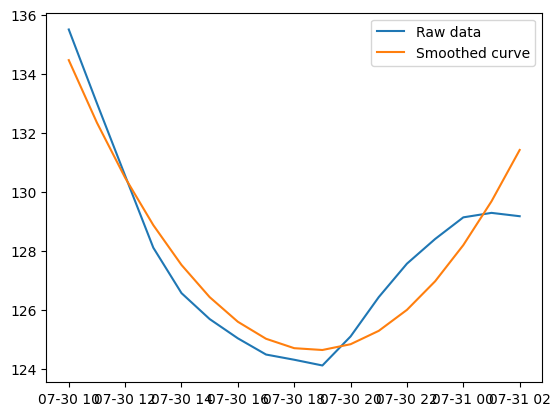

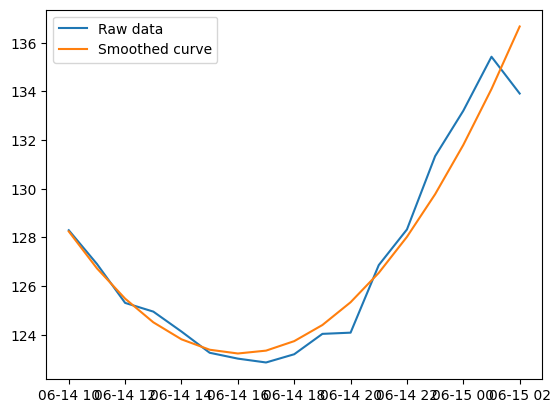

In [18]:
k = 2
b = []
data_var = np.array(data_var)
data_date = np.array(data_date)
k_largest = data_var.argsort()[-k:]
for date1,date2 in data_date[k_largest]:
    is_smooth(date1,date2,[],[],threshold,flag=True)

1

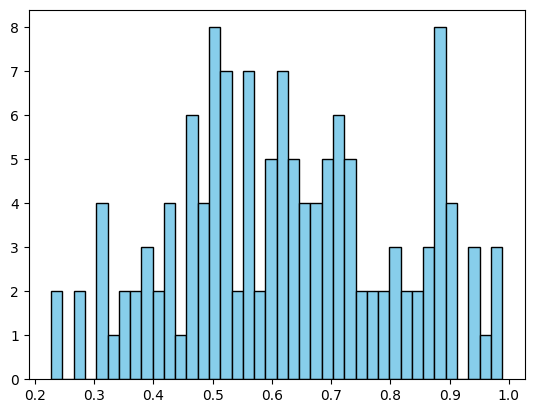

In [19]:
plt.hist(data_var, bins=40, color='skyblue', edgecolor='black')
1

In [22]:
df_only = pd.read_csv(get_root() +'/data/processed/integrated.csv', encoding='utf-8')
df_only['datetime'] = pd.to_datetime(df_only['date']) + pd.to_timedelta(df_only['hour'], unit='h')
df_only["is_good_pick"] = False

In [27]:
flag_arr = (df_only["name"] == "پرند") & (df_only["code"] == "G11")

for date1,date2 in data_date:
    flag_array = ((df_only['datetime'] >= np.datetime64(date1)) & (df_only['datetime'] <= np.datetime64(date2)))
    df_only["is_good_pick"] = df_only["is_good_pick"] | (flag_arr & flag_array)
    
#df_only.loc[flag_arr,"is_good_pick"] = True

In [30]:
np.count_nonzero(df_only["is_good_pick"].to_numpy())

2422

In [31]:
df_only.to_csv(path_or_buf=get_root() +'/data/processed/prediction_only.csv', sep=',', header=True, index=False,na_rep='NULL')